In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys, platform, os
import math
import matplotlib
from matplotlib import cm
from matplotlib import pyplot as plt
import numpy as np
from scipy import integrate as integrate
import camb
from camb import model, initialpower
print('Using CAMB %s installed at %s'%(camb.__version__,os.path.dirname(camb.__file__)))

Using CAMB 1.3.6 installed at /home/carter/.venv.CAMB_gammaprime/lib/python3.10/site-packages/camb


In [2]:
H0_inv = 2997.8 #h^{-1} Mpc

In [3]:

def get_closest_index(search_value, array):
    """Get the index of the closest value in the strictly increasing numpy array array to the value search_value.
    If two elements of the array are equally close to the search value, returns the earlier index."""
    if(array.size==1):
        return 0
    if not (np.all(array[1:]>array[:-1])):
        raise Exception("Array is not strictly increasing.")
    if(search_value<=array[0]):
        return 0
    if(search_value>=array[-1]):
        return array.size-1
    #search value now guaranteed to be in the range (array[0], array[-1])
    last_smaller_i = np.where(array<search_value)[0][-1]
    last_smaller_val = array[last_smaller_i]
    first_bigger_i = last_smaller_i+1
    first_bigger_val = array[first_bigger_i]
    if(abs(search_value-first_bigger_val)<abs(search_value-last_smaller_val)):
        return first_bigger_i
    else:
        return last_smaller_i

In [4]:
#Physics methods
def E_of_z(z : float,
           omM : float = .3, omL : float = .7, omR : float = 0, w : float=-1):
    omK = 1-(omM+omL+omR)
    return (omM*(1+z)**3+omL*(1+z)**(3*(1+w))+omR*(1+z)**4+omK*(1+z)**2)**.5
def r_of_z(z, omM = .3, omL = .7, omR = 0, w=-1):
    if(z==0):
        return 0
    return integrate.quad(lambda x: E_of_z(x, omM = omM, omL = omL, omR = omR, w=w)**-1, 0, z)[0]

def get_FPK_errorbars(Pk_theory, k, dk, z, dz, om_survey, n, r):
    """Generate Feldman-Kaiser-Peacock error bars for a point (k,z,P(k,z))
    from a survey with given dk, dz, number density of galaxy n [sr^-1] and Omega_survey [sr]"""
    dV_survey = om_survey*r**2/E_of_z(z)*dz #r=r(z) is the comoving distance, H=H(z), simply hubble parameter
    dV_eff = (n*Pk_theory/(1+n*Pk_theory))**2*dV_survey #P = P(k,z), n = n(z) = number density of galaxies
    sigma2 = 4*math.pi**2*Pk_theory**2/(k**2*dk*dV_eff)*H0_inv**-3
    sigma = math.sqrt(sigma2)
    return(sigma)

In [5]:
def sample_Pk(mink : float = None, maxk : float = None, dk_k : float = 1,
              k_array = None, pk_curve = None, z : float= None,
              cosmoParams : camb.CAMBparams = None,
              dz = None, omSurvey = None, n_objects = None,
              plot = None, color = 'k', capsize = 3,
              dChi2 = None, refPk = None):
    H0 = cosmoParams.H0
    h = H0/100
    omM = cosmoParams.ombh2/h**2+cosmoParams.omch2/h**2
    omL = 1-cosmoParams.omk-omM

    H = E_of_z(z, omM = omM, omL = omL)*H0_inv**-1

    k_lo= mink
    k_hi = mink+dk_k*mink

    while(k_hi<maxk):
        k_index = get_closest_index(math.sqrt(k_lo*k_hi), k_array)
        pk = pk_curve[k_index]
        k_sample = k_array[k_index]
        dk = k_hi-k_lo
        error_y = get_Pk_errorbars(pk, k_sample, dk, z, dz, omSurvey, n_objects, r_of_z(z, omM = omM, omL = omL))
        error_x = [[k_sample-k_lo],[k_hi-k_sample]]
        plot.errorbar(k_sample,pk,yerr = error_y, xerr = error_x, marker='.',color=color, capsize = capsize)

        if dChi2 is not None and refPk is not None:
            dChi2.append((pk-refPk[k_index])/error_y**2)
        
        k_lo = k_hi
        k_hi = k_lo+dk_k*k_lo

Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


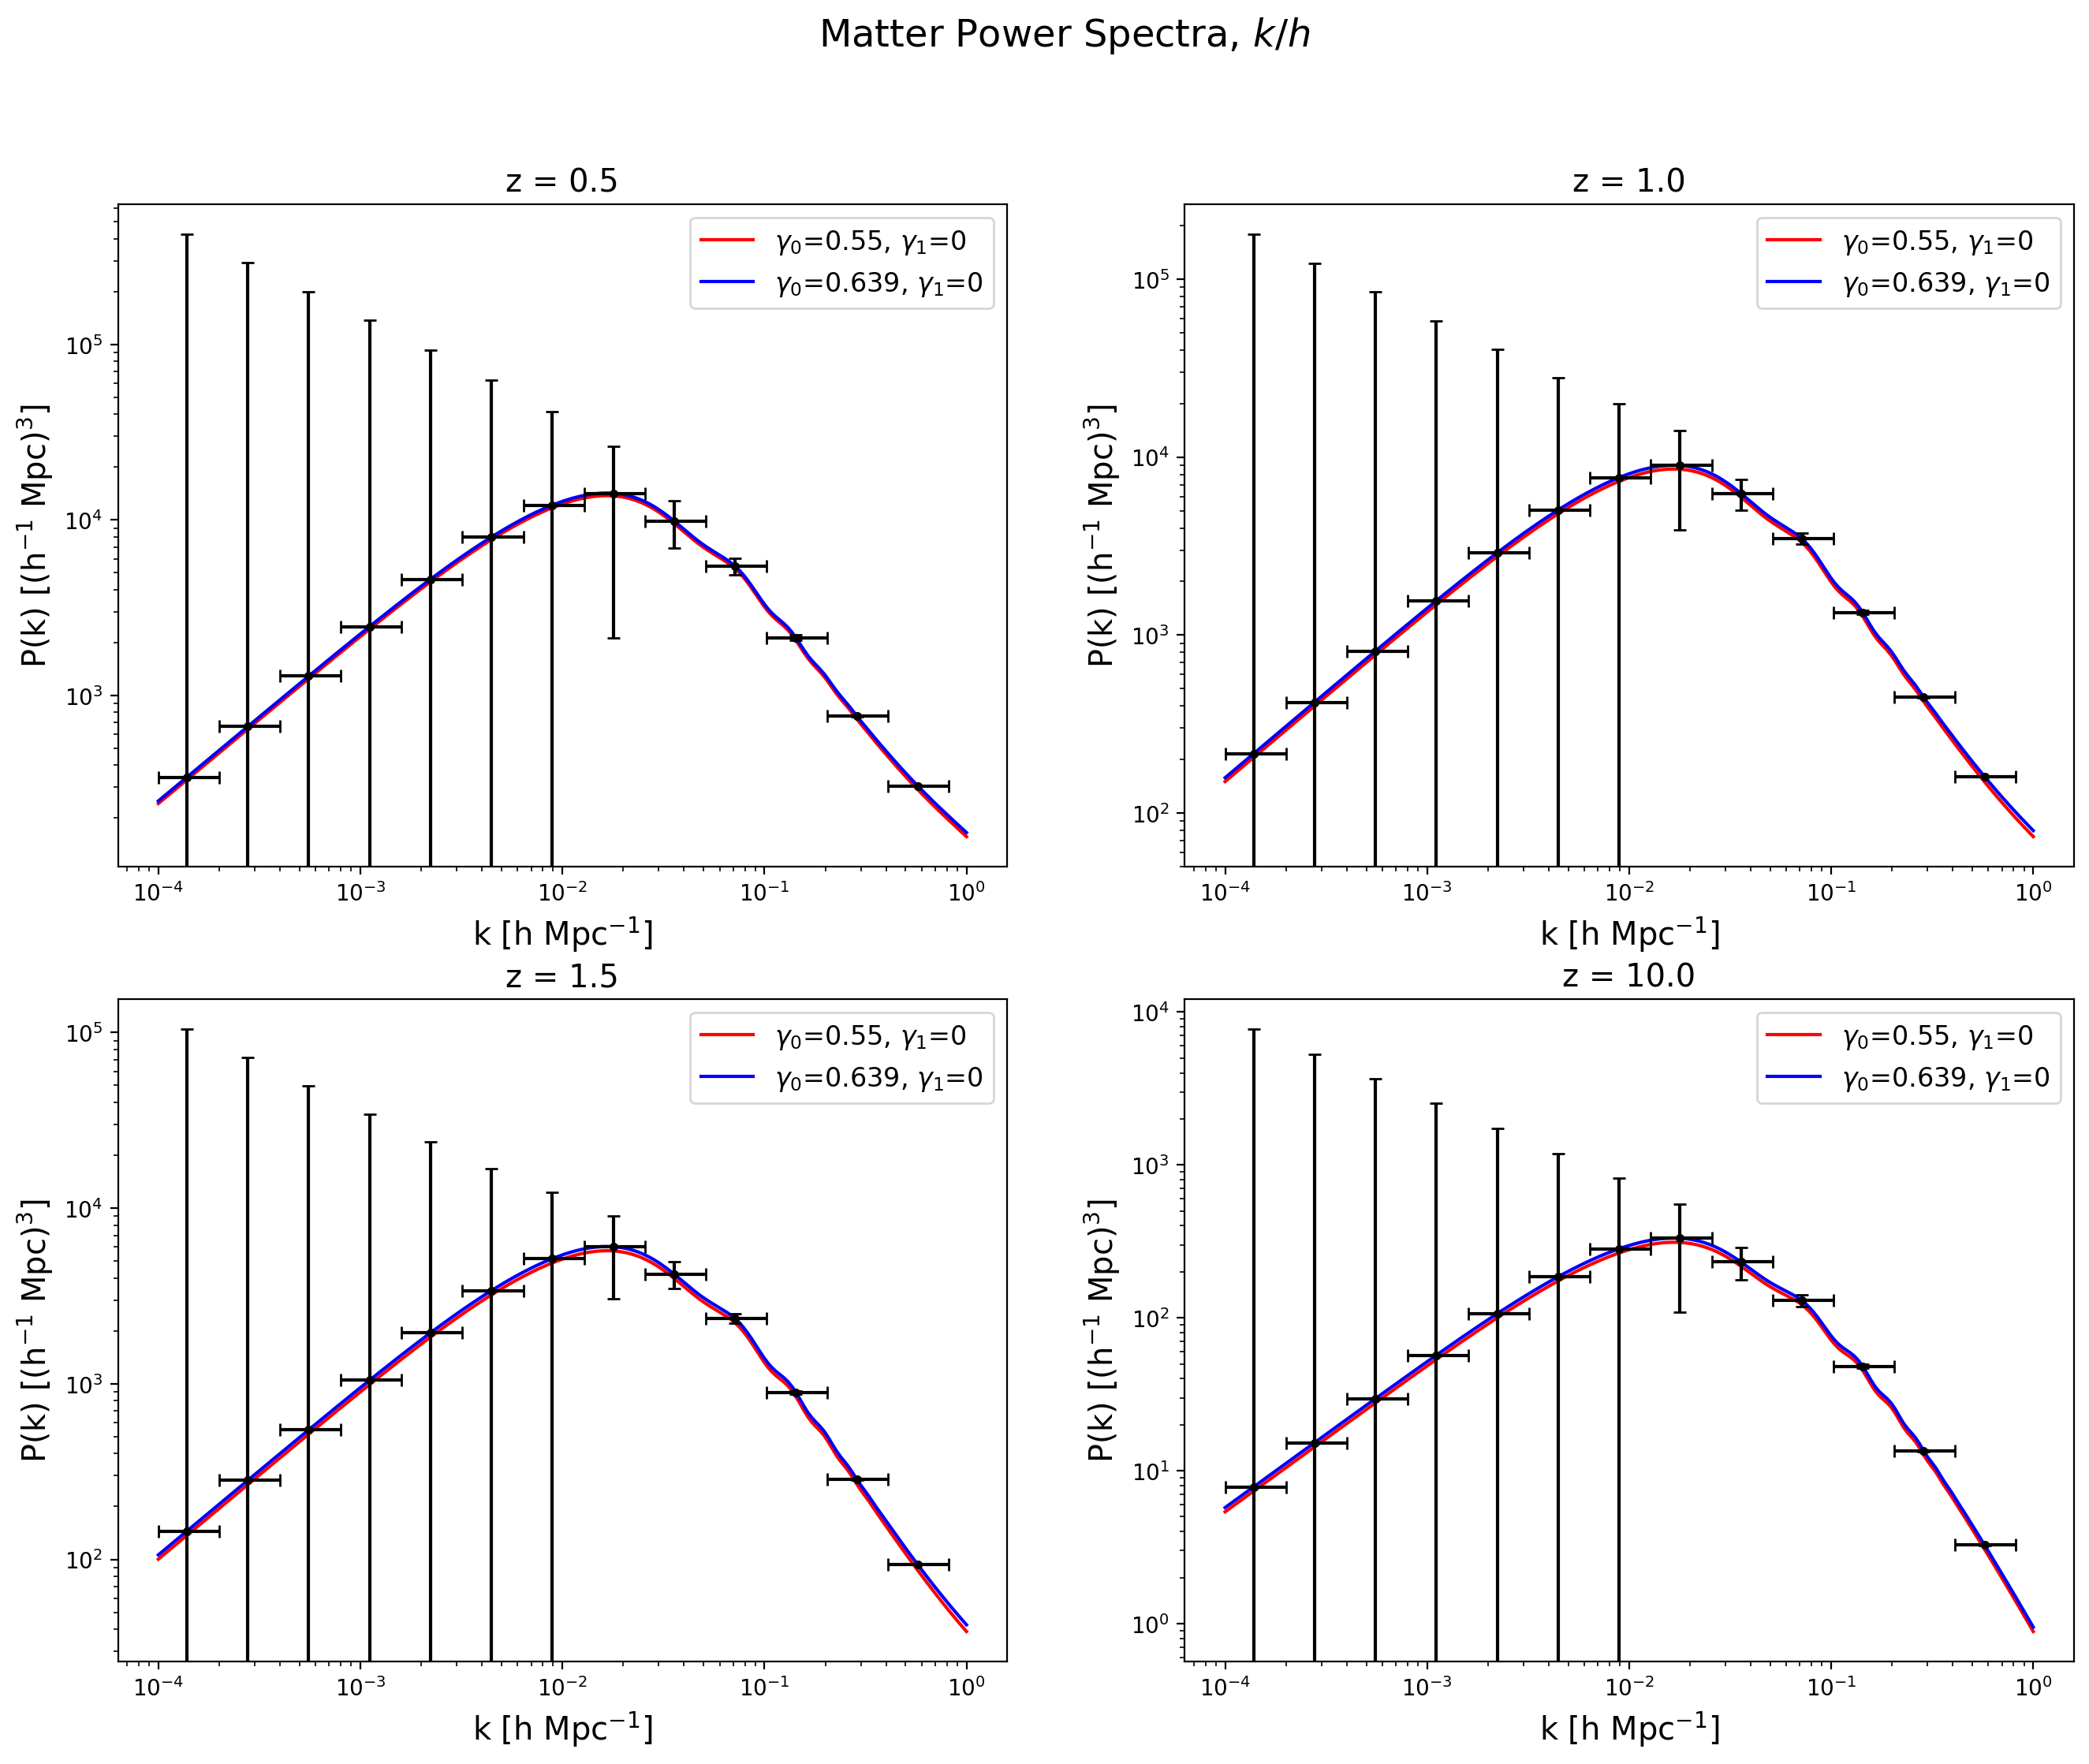

In [6]:
mink = 1e-4
maxk = 1
dk_k = 1
survey_params = {'Omega_survey': 1400*(math.pi/180)**2/(4*math.pi),
                 'dz': .1,
                 'n_objects' : 15*3600*(180/math.pi)**2}

fig, ax = plt.subplots(2,2, figsize=(16,12))
fig.suptitle('Matter Power Spectra, $k/h$', fontsize='xx-large')
#list of parameter values and their respective colors to be plotted, in the form [gamma0, gamma1, non-linear color]
vals_and_colors = np.array([[.55, 0, 'red'], [.639, 0, 'blue']])
dChi2_list = []
for i in vals_and_colors:
    gamma0 = float(i[0])
    gamma1 = float(i[1])
    pars = camb.CAMBparams()
    pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122, mnu=0.06, omk=0, tau=0.06,gamma0=gamma0,gamma1=gamma1)
    pars.set_matter_power(redshifts=[10, .5, 1, 1.5], kmax=2.0)

    #Non-Linear spectra (Halofit)
    pars.NonLinear = model.NonLinear_both
    results = camb.get_results(pars)
    results.calc_power_spectra(pars)
    kh_nonlin, z_nonlin, pk_nonlin = results.get_matter_power_spectrum(minkh=mink, maxkh=maxk, npoints = 200)

    for j, (redshift, line) in enumerate(zip(z_nonlin,['-','-', '-', '-'])):
        ax[min(1,j-j%2),j%2].loglog(kh_nonlin, pk_nonlin[j,:], color=i[2], ls = '-', label = '$\gamma_0$='+i[0]+', $\gamma_1$='+i[1])
        ax[min(1,j-j%2), j%2].set_title('z = '+str(redshift), fontsize='x-large')
        if(gamma0>.56):
            sample_Pk(mink = mink, maxk = maxk, dk_k = dk_k,
                      k_array = kh_nonlin, pk_curve = pk_nonlin[j,:], z=redshift,
                      dz = survey_params['dz'], omSurvey = survey_params['Omega_survey'], n_objects = survey_params['n_objects'],
                      cosmoParams = pars, plot = ax[min(1,j-j%2),j%2])
        
    #plt.title('Matter power at z=%s and z= %s'%tuple(z))


for axl in np.array(ax).flatten():
    axl.legend(fontsize='large')
    axl.set_xlabel('k [h Mpc$^{-1}$]', fontsize='x-large')
    axl.set_ylabel('P(k) [(h$^{-1}$ Mpc)$^{3}$]', fontsize='x-large')
plt.show()

$\Chi^2$ = 43.931992548069644


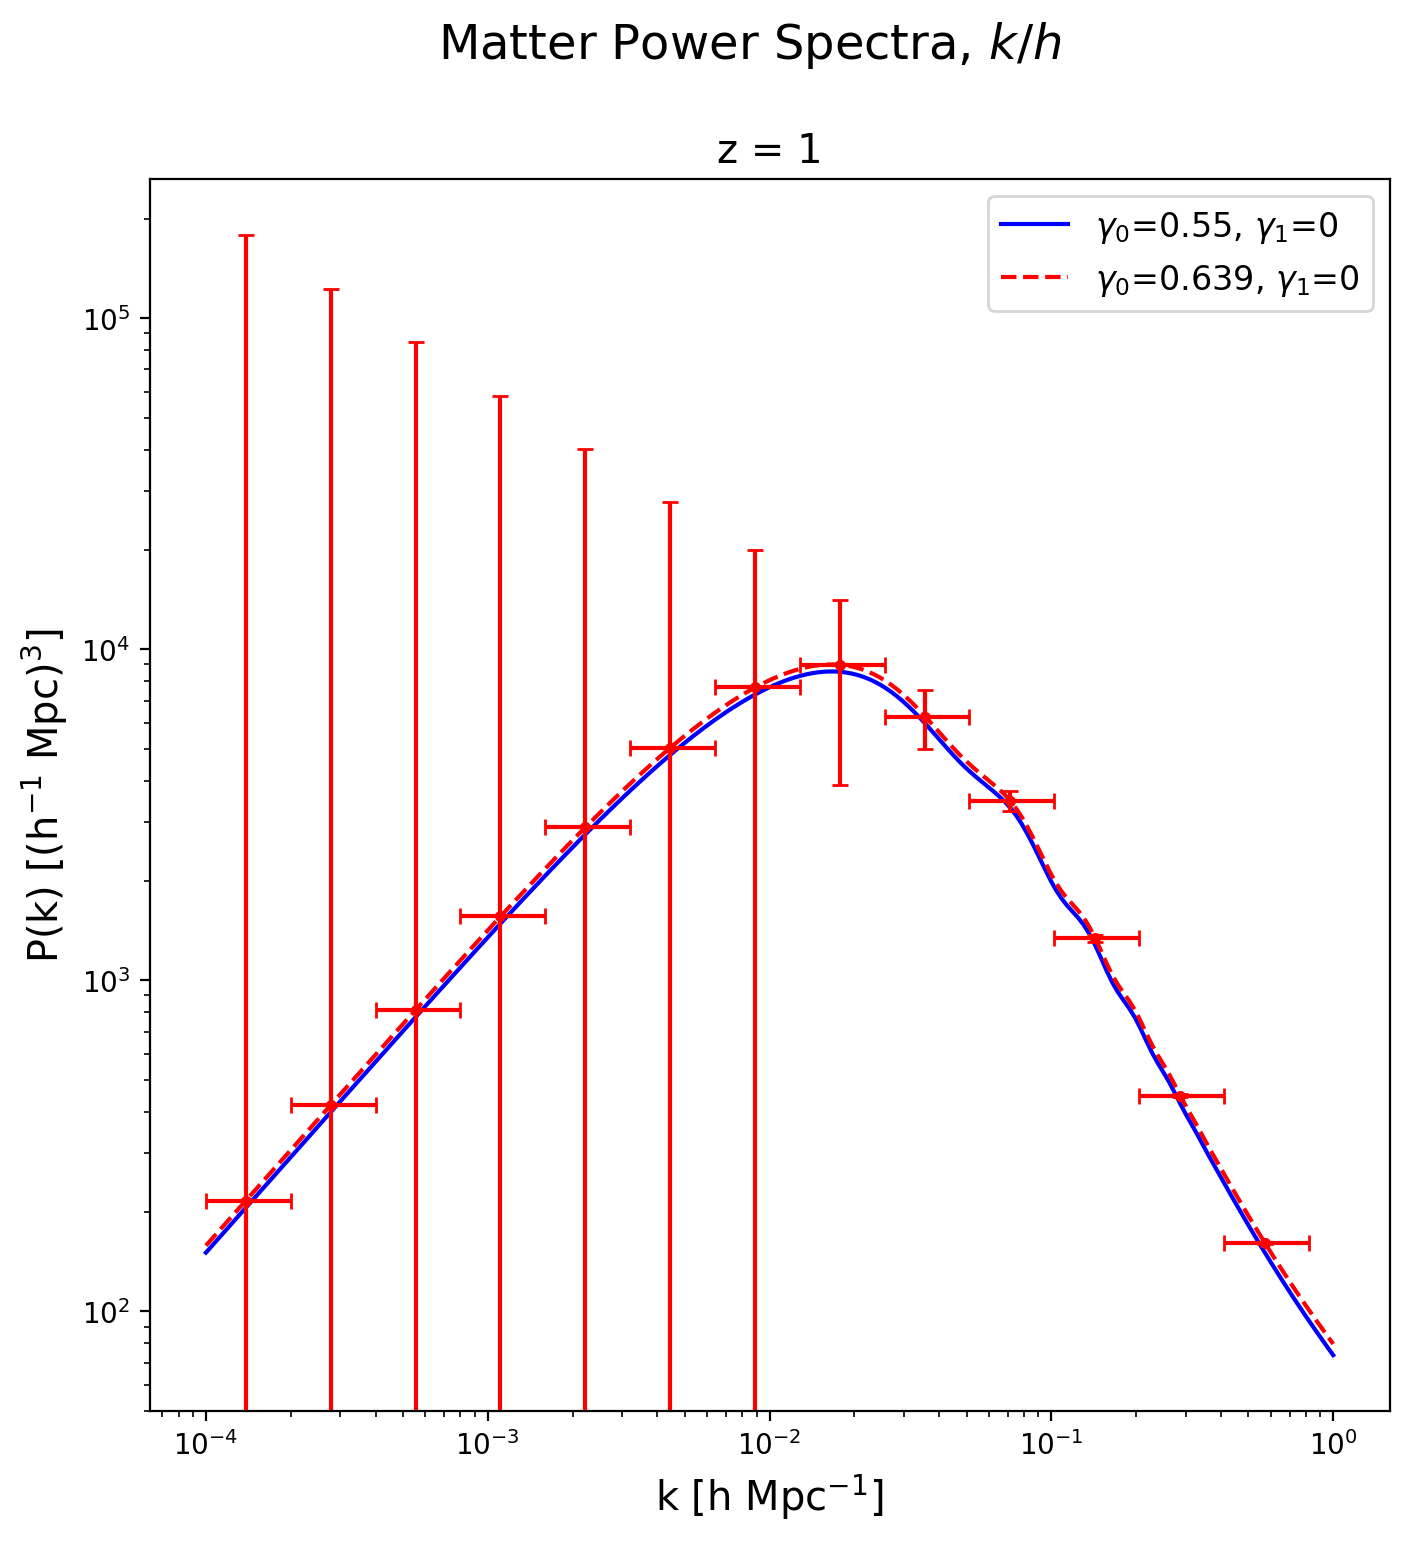

In [7]:
mink = 1e-4
maxk = 1
dk_k = 1
survey_params = {'Omega_survey': 1400*(math.pi/180)**2/(4*math.pi),
                 'dz': .1,
                 'n_objects' : 15*3600*(180/math.pi)**2}

redshift = 1

fig, ax = plt.subplots(1,1, figsize=(8,8))
fig.suptitle('Matter Power Spectra, $k/h$', fontsize='xx-large')
#list of parameter values and their respective colors to be plotted, in the form [gamma0, gamma1, non-linear color]
vals_and_colors = np.array([[.55, 0, 'red'], [.639, 0, 'blue']])
dChi2_list = []

gamma0 = .55
gamma1 = 0
pars = camb.CAMBparams()
pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122, mnu=0.06, omk=0, tau=0.06,gamma0=gamma0,gamma1=gamma1)
pars.set_matter_power(redshifts=[redshift], kmax=2.0)

#Non-Linear spectra (Halofit)
pars.NonLinear = model.NonLinear_both
results = camb.get_results(pars)
results.calc_power_spectra(pars)
kh_nonlin, z_nonlin, pk_nonlin = results.get_matter_power_spectrum(minkh=mink, maxkh=maxk, npoints = 200)

pk_ref = pk_nonlin[0,:]

ax.loglog(kh_nonlin, pk_nonlin[0,:], color='blue', ls = '-', label = '$\gamma_0$='+str(gamma0)+', $\gamma_1$='+str(gamma1))
ax.set_title('z = '+str(redshift), fontsize='x-large')

#plt.title('Matter power at z=%s and z= %s'%tuple(z))

gamma0 = .639
gamma1 = 0
pars = camb.CAMBparams()
pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122, mnu=0.06, omk=0, tau=0.06,gamma0=gamma0,gamma1=gamma1)
pars.set_matter_power(redshifts=[redshift], kmax=2.0)

#Non-Linear spectra (Halofit)
pars.NonLinear = model.NonLinear_both
results = camb.get_results(pars)
results.calc_power_spectra(pars)
kh_nonlin, z_nonlin, pk_nonlin = results.get_matter_power_spectrum(minkh=mink, maxkh=maxk, npoints = 200)


ax.loglog(kh_nonlin, pk_nonlin[0,:], color='red', ls = '--', label = '$\gamma_0$='+str(gamma0)+', $\gamma_1$='+str(gamma1))
ax.set_title('z = '+str(redshift), fontsize='x-large')


sample_Pk(mink = mink, maxk = maxk, dk_k = dk_k,
    k_array = kh_nonlin, pk_curve = pk_nonlin[0,:], z=redshift,
    dz = survey_params['dz'], omSurvey = survey_params['Omega_survey'], n_objects = survey_params['n_objects'],
    cosmoParams = pars, plot = ax, color='red',
    dChi2=dChi2_list, refPk = pk_ref)

print(r'$\Chi^2$ = ' + str(np.sum(dChi2_list)))    

ax.legend(fontsize='large')
ax.set_xlabel('k [h Mpc$^{-1}$]', fontsize='x-large')
ax.set_ylabel('P(k) [(h$^{-1}$ Mpc)$^{3}$]', fontsize='x-large')
plt.show()